In [1]:
%matplotlib inline
import os
from sdypy import EMA
import numpy as np
import matplotlib.pyplot as plt 
import scipy.io
from scipy.signal import find_peaks
import re
import json as js
import pandas as pd
import time as tm

In [2]:
# data_root = r'G:\.shortcut-targets-by-id\1k1B8zPb3T8H7y6x0irFZnzzmfQPHMRPx\Illimited Lab Projects\Completed Projects\Multi-Phase Structures\Experimental\Data\Modal Testing\Free-Free Heat\converted'
data_root = r'G:\.shortcut-targets-by-id\1k1B8zPb3T8H7y6x0irFZnzzmfQPHMRPx\Illimited Lab Projects\Completed Projects\Multi-Phase Structures\Experimental\Data\Modal Testing\Cantilever Heat\converted'
file_list = os.listdir(data_root)

file_path = os.path.join(data_root, 'modal_properties.json')
if not os.path.exists(file_path):
    initialize_properties = {'filename': [], 
                        'time_stamp': [], 
                        'specimen': [], 
                        'acc_location': [], 
                        'BC': [], 
                        'version': [], 
                        'natural frequencies': [], 
                        'damping ratios': []}
    with open(file_path, 'w') as file:
        js.dump(initialize_properties, file)
with open(file_path, 'r') as file:
    properties = js.load(file)

In [3]:
# current_file = file_list[0]
# integers_groups = [int(num) for num in re.findall(r'\d+', current_file)]
# time_stamp = integers_groups[-2]
# specimen = integers_groups[0]
# acc_location = integers_groups[1]
# letter_groups = re.findall(r'[a-zA-Z]+', current_file)
# BC = letter_groups[0]
# version = letter_groups[1]
# data = scipy.io.loadmat(os.path.join(data_root, current_file))
# time = data['Time']
# dt = time[1] - time[0]
# chan1 = data['A'][:, 0]
# chan2 = data['A'][:, 1]
# peaks, _ = find_peaks(chan1)
# peak = peaks[np.argmax(chan1[peaks])]

current_file = file_list[0]
integers_groups = [int(num) for num in re.findall(r'\d+', current_file)]
time_stamp = integers_groups[-1]
specimen = integers_groups[0]
version = integers_groups[-1]
letter_groups = re.findall(r'[a-zA-Z]+', current_file)
BC = letter_groups[0]
acc_location = letter_groups[-1]
data = scipy.io.loadmat(os.path.join(data_root, current_file))
time = data['Time']
dt = time[1] - time[0]
chan1 = data['Hammer'].squeeze()
chan2 = data['acc'].squeeze()
peaks, _ = find_peaks(chan1)
peak = peaks[np.argmax(chan1[peaks])]

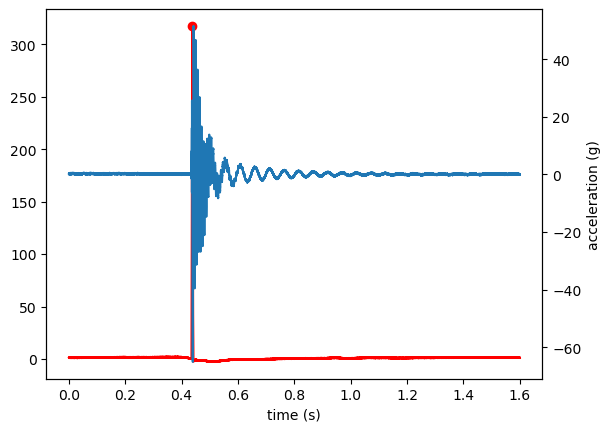

In [4]:

fig, ax = plt.subplots()
ax.plot(time, chan1,'r', label='force')
ax.plot(time[peak], chan1[peak], 'ro', label='peaks')
ax.set_xlabel('time (s)')

ax2 = ax.twinx()
ax2.plot(time, chan2, label='acceleration')
ax2.set_ylabel('acceleration (g)')
plt.show()


In [5]:
Duration  = 0.7
steps = int(Duration/dt)
start = peak - 500
end = start + steps
time_c = time[start:end] - time[start]
force = chan1[start:end]
force[int(0.02/dt):] = 0
force[force<0] = 0
acc = chan2[start:end] - np.mean(chan2[start:end])

In [6]:
%matplotlib qt
fig, ax = plt.subplots()
ax.plot(time_c, force,'b', label='force')
ax.set_ylabel('Force (N)')
ax.set_xlabel('time (s)')

ax2 = ax.twinx()
ax2.plot(time_c, acc,'r', label='acceleration')
ax2.set_ylabel('acceleration (g)')
plt.show()

In [7]:
n = len(acc)
fs = 1/dt
freq = np.fft.rfftfreq(n, 1/fs)

In [8]:
Acc = np.fft.rfft(acc, n=n) / n
Force = np.fft.rfft(force, n=n) / n

# Normalize the one-sided amplitude spectra:
Acc[ 1:] *= 2
Force[1:] *= 2
Acc.shape, Force.shape

((17921,), (17921,))

In [9]:
plt.figure(figsize=(15, 5))
plt.semilogy(freq, np.abs(Force), label='Force')
plt.semilogy(freq, np.abs(Acc), label='Displacement')
plt.xlim(0, 1000)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Force [N], Acceleration [m s^-2] amplitude spectra')
plt.legend()

In [10]:
S_xx = 1/Duration * np.conj(Acc) * Acc
S_ff = 1/Duration * np.conj(Force) * Force
S_xf = 1/Duration * np.conj(Acc) * Force
S_fx = 1/Duration * np.conj(Force) * Acc

H_1 = S_fx / S_ff
H_2 = S_xx / S_xf
H_v = (H_1 * H_2)**0.5

In [11]:
%matplotlib qt
fig, ax = plt.subplots(2,1,figsize=(15, 9))
# ax[0].plot(freq, np.abs(H_1), 'k', label='|H1|')
# ax[0].plot(freq, np.abs(H_2), 'r', label='|H2|')
# ax[0].plot(freq, np.abs(H_v), 'b', label='|Hv|')
ax[0].semilogy(freq, np.abs(H_1), 'k', label='|H1|')
ax[0].semilogy(freq, np.abs(H_2), 'r', label='|H2|')
ax[0].semilogy(freq, np.abs(H_v), 'b', label='|Hv|')
ax[0].set_ylabel('|H|')
ax[0].set_xlim(0, 1000)
ax[0].set_ylim(0.001, 50)
ax[0].legend()

phase_H1 = np.unwrap(np.angle(H_1))
phase_H2 = np.unwrap(np.angle(H_2))
phase_Hv = np.unwrap(np.angle(H_v))

ax[1].plot(freq, phase_H1, 'k', label=f'angle H1')
ax[1].plot(freq, phase_H2, 'r', label=f'angle H2')
# ax[1].plot(freq, phase_Hv, 'b', label=f'angle Hv')
ax[1].legend()
plt.show()

In [12]:
cam = EMA.Model(H_1, freq, lower=50, upper=1000, pol_order_high=80, frf_type = 'accelerance')
cam.get_poles(show_progress=True)
# cam.select_poles()
cam.select_closest_poles(np.array([165, 314]), )
cam.print_modal_data()


  0%|                                                                        | 0/80 [00:00<?, ?it/s]c:\Users\thijsmas\AppData\Local\anaconda3\Lib\site-packages\sdypy\EMA\EMA.py:312: RuntimeWarning: invalid value encountered in log
  poles = -np.log(sr) / self.sampling_time
100%|██████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 110.69it/s]

   Nat. f.      Damping
-----------------------
1)  144.6	0.0332
2)  289.5	0.0427


In [39]:
%matplotlib qt
df = pd.DataFrame(columns=['Time Stamp', 'Specimen', 'Acc Location', 'BC', 'Version', 'natural frequencies', 'damping ratios'])
for current_file in file_list:
    if not current_file.endswith('.mat'):
        continue
    print(current_file)
    integers_groups = [int(num) for num in re.findall(r'\d+', current_file)]
    time_stamp = integers_groups[-2]
    specimen = integers_groups[0]
    version = integers_groups[-1]
    letter_groups = re.findall(r'[a-zA-Z]+', current_file)
    BC = letter_groups[0]
    acc_location = letter_groups[-3]
    # integers_groups = [int(num) for num in re.findall(r'\d+', current_file)]
    # time_stamp = integers_groups[-2]
    # specimen = integers_groups[0]
    # acc_location = integers_groups[1]
    # letter_groups = re.findall(r'[a-zA-Z]+', current_file)
    # BC = letter_groups[0]
    # version = letter_groups[1]
    data = scipy.io.loadmat(os.path.join(data_root, current_file))
    time = data['Time']
    dt = time[1] - time[0]
    # chan1 = data['A'][:, 0]
    # chan2 = data['A'][:, 1]
    chan1 = data['Hammer'].squeeze()
    chan2 = data['acc'].squeeze()
    peaks, _ = find_peaks(chan1)
    peak = peaks[np.argmax(chan1[peaks])]

    start = peak - 500
    end = start + steps
    time_c = time[start:end] - time[start]
    force = chan1[start:end]
    force[int(0.02/dt):] = 0
    force[force<0] = 0
    acc = chan2[start:end] - np.mean(chan2[start:end])

    fig, ax = plt.subplots()
    ax.plot(time_c, acc,'r', label='acceleration')
    ax.set_ylabel('acceleration (g)')
    ax.set_xlabel('time (s)')
    plt.legend()

    ax2 = ax.twinx()
    ax2.plot(time_c, force,'b', label='force')
    ax2.set_ylabel('Force (N)')
    plt.legend()
    plt.show()
    plt.savefig(os.path.join(data_root, 'figures', 'signal', f'{current_file}.png'))
    tm.sleep(0.2)
    
    n = len(acc)
    fs = 1/dt
    freq = np.fft.rfftfreq(n, 1/fs)

    Acc = np.fft.rfft(acc, n=n) / n
    Force = np.fft.rfft(force, n=n) / n

    # Normalize the one-sided amplitude spectra:
    Acc[ 1:] *= 2
    Force[1:] *= 2

    S_xx = 1/Duration * np.conj(Acc) * Acc
    S_ff = 1/Duration * np.conj(Force) * Force
    S_xf = 1/Duration * np.conj(Acc) * Force
    S_fx = 1/Duration * np.conj(Force) * Acc

    H_1 = S_fx / S_ff
    H_2 = S_xx / S_xf
    H_v = (H_1 * H_2)**0.5

    fig, ax = plt.subplots(2,1,figsize=(15, 9))
    # ax[0].plot(freq, np.abs(H_1), 'k', label='|H1|')
    # ax[0].plot(freq, np.abs(H_2), 'r', label='|H2|')
    # ax[0].plot(freq, np.abs(H_v), 'b', label='|Hv|')
    ax[0].semilogy(freq, np.abs(H_1), 'k', label='|H1|')
    ax[0].semilogy(freq, np.abs(H_2), 'r', label='|H2|')
    ax[0].semilogy(freq, np.abs(H_v), 'b', label='|Hv|')
    ax[0].set_ylabel('|H|')
    ax[0].set_xlim(0, 1000)
    ax[0].set_ylim(0.001, 50)
    ax[0].legend()

    phase_H1 = np.unwrap(np.angle(H_1))
    phase_H2 = np.unwrap(np.angle(H_2))
    phase_Hv = np.unwrap(np.angle(H_v))

    ax[1].plot(freq, phase_H1, 'k', label=f'angle H1')
    ax[1].plot(freq, phase_H2, 'r', label=f'angle H2')
    # ax[1].plot(freq, phase_Hv, 'b', label=f'angle Hv')
    ax[1].legend()
    ax[1].set_ylabel('phase (rad)')
    ax[1].set_xlabel('Frequency (Hz)')
    plt.show()
    plt.savefig(os.path.join(data_root, 'figures', 'FRF', f'{current_file}.png'))
    tm.sleep(0.2)
    plt.close()

    cam = EMA.Model(H_1, freq, lower=10, upper=600, pol_order_high=100, frf_type = 'accelerance')
    cam.get_poles(show_progress=True)
    cam.select_poles()
    # cam.select_closest_poles(np.array([165, 314]), )
    # cam.select_closest_poles(np.array([166, 315, 368, 422, 613, 754]), )
    # cam.select_closest_poles(np.array([143, 197, 228, 256, 289]), )
    # cam.print_modal_data()

    # Add data to df
    df.loc[len(df)] = {'Time Stamp': time_stamp,
                       'Specimen': specimen,
                       'Acc Location': acc_location, 
                       'BC': BC,
                       'Version': version, 
                       'natural frequencies': cam.nat_freq,
                       'damping ratios': cam.nat_xi}
    H1_r, A1_r = cam.get_constants(whose_poles='own', FRF_ind='all')
    fig, ax = plt.subplots(figsize=(15, 9))
    ax.semilogy(freq, np.abs(H_1), 'k', label='|H1|')
    ax.set_ylabel('|H|')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_xlim(0, 600)
    ax.set_ylim(0.001, 50)
    ax.legend()
    ax.semilogy(freq[:len(H1_r[0])], np.abs(H1_r[0]), 'r', label='|H1| reconstructed')
    plt.legend()
    plt.show()
    plt.savefig(os.path.join(data_root, 'figures', 'FRF','Reconstructed', f'{current_file}_recon.png'))
    tm.sleep(0.2)
    plt.close()

df

C1rh24_0_test1.mat


100%|█████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 74.92it/s]


C1rh24_0_test2.mat


100%|█████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 75.10it/s]


KeyboardInterrupt: 

In [15]:
# df2.to_pickle(os.path.join(data_root, 'AIAA_2024.pkl'))


In [14]:
df2 = pd.read_pickle(os.path.join(data_root, 'AIAA_2024.pkl'))
current_file = 'C2rh24_0_test1.mat'

integers_groups = [int(num) for num in re.findall(r'\d+', current_file)]
time_stamp = integers_groups[-2]
specimen = integers_groups[0]
version = integers_groups[-1]
letter_groups = re.findall(r'[a-zA-Z]+', current_file)
BC = letter_groups[0]
acc_location = letter_groups[-3]

data = scipy.io.loadmat(os.path.join(data_root, current_file))
time = data['Time']
dt = time[1] - time[0]

chan1 = data['Hammer'].squeeze()
chan2 = data['acc'].squeeze()
peaks, _ = find_peaks(chan1)
peak = peaks[np.argmax(chan1[peaks])]

start = peak - 500
end = start + steps
time_c = time[start:end] - time[start]
force = chan1[start:end]
force[int(0.02/dt):] = 0
force[force<0] = 0
acc = chan2[start:end] - np.mean(chan2[start:end])

n = len(acc)
fs = 1/dt
freq = np.fft.rfftfreq(n, 1/fs)

Acc = np.fft.rfft(acc, n=n) / n
Force = np.fft.rfft(force, n=n) / n

# Normalize the one-sided amplitude spectra:
Acc[ 1:] *= 2
Force[1:] *= 2

S_xx = 1/Duration * np.conj(Acc) * Acc
S_ff = 1/Duration * np.conj(Force) * Force
S_xf = 1/Duration * np.conj(Acc) * Force
S_fx = 1/Duration * np.conj(Force) * Acc

H_1 = S_fx / S_ff
H_2 = S_xx / S_xf
H_v = (H_1 * H_2)**0.5

cam = EMA.Model(H_1, freq, lower=10, upper=600, pol_order_high=150, frf_type = 'accelerance')
cam.get_poles(show_progress=True)
cam.select_poles()

# Add data to df
row = df2.loc[(df2['Time Stamp'] == time_stamp) & (df2['Specimen'] == specimen) & (df2['Acc Location'] == acc_location) & (df2['BC'] == BC) & (df2['Version'] == version)]
df2.at[row.index[0], 'natural frequencies'] = cam.nat_freq
df2.at[row.index[0], 'damping ratios'] = cam.nat_xi

H1_r, A1_r = cam.get_constants(whose_poles='own', FRF_ind='all')
fig, ax = plt.subplots(figsize=(15, 9))
ax.semilogy(freq, np.abs(H_1), 'k', label='|H1|')
ax.set_ylabel('|H|')
ax.set_xlabel('Frequency (Hz)')
ax.set_xlim(0, 600)
ax.set_ylim(0.001, 50)
ax.legend()
ax.semilogy(freq[:len(H1_r[0])], np.abs(H1_r[0]), 'r', label='|H1| reconstructed')
plt.legend()
plt.show()
plt.savefig(os.path.join(data_root, 'figures', 'FRF','Reconstructed', f'{current_file}_recon.png'))



100%|█████████████████████████████████████████████████████████████| 150/150 [00:04<00:00, 36.39it/s]


In [29]:
# df = pd.read_pickle(os.path.join(data_root, 'AIAA_2024.pkl'))
df[df['Acc Location'] == 'rh']


,Time Stamp,Specimen,Acc Location,BC,Version,natural frequencies,damping ratios
0,0,1,rh,C,1,"[19.045555688086164, 106.31431620608755, 144.5...","[0.0439530979587263, 0.008677978791947316, 0.0..."
1,0,1,rh,C,2,"[19.151331184046718, 144.6551391248911, 194.10...","[0.06161939823006782, 0.03396493070938725, 0.0..."
2,0,1,rh,C,3,"[18.896812324408906, 144.56512002968176, 158.9...","[0.044340925039622156, 0.03455832508462471, 0...."
6,10,1,rh,C,1,"[18.13960224898966, 129.55448153139065, 140.49...","[0.04798992830829868, 0.014783228911674828, 0...."
7,10,1,rh,C,2,"[18.10750710417404, 144.55187649097107, 185.93...","[0.048575064322248424, 0.03909098884936847, 0...."
8,10,1,rh,C,3,"[18.257758251591543, 144.09712580031226, 183.8...","[0.043653148219731895, 0.03962588121160298, 0...."
9,15,1,rh,C,1,"[17.33123946277306, 129.62552245662377, 142.04...","[0.05622657816128259, 0.0871078971999863, 0.04..."
10,15,1,rh,C,2,"[17.555622829699338, 132.03245328712913, 141.9...","[0.041328528857500525, 0.035238542599769045, 0..."
11,15,1,rh,C,3,"[17.27176078177669, 135.4063575631012, 142.039...","[0.04792762844687069, 0.01039425617796582, 0.0..."
15,23,1,rh,C,1,"[16.03014934726724, 127.76803660781985, 134.17...","[0.06353139179004454, 0.0587550440902431, 0.05..."


In [29]:
def time_to_dT(time):
    return  0.95*time
len(df[df['Acc Location'] == 'rh'])

54

In [38]:
# Increase font size
time_stamp_array = df[df['Acc Location'] == 'rh']['Time Stamp'].values
sorted_indices      = np.argsort(time_stamp_array)
time_stamp_array    = time_stamp_array[sorted_indices]
natural_frequencies_array = df[df['Acc Location'] == 'rh']['natural frequencies'].values[sorted_indices]
specimen_array      = df[df['Acc Location'] == 'rh']['Specimen'].values[sorted_indices]
version_vec         = df[df['Acc Location'] == 'rh']['Version'].values[sorted_indices]
# natural_frequencies = np.vstack(natural_frequencies_array)
damping_ratios_array = df[df['Acc Location'] == 'rh']['damping ratios'].values[sorted_indices]
# damping_ratios = np.vstack(damping_ratios_array)
colors = ['k', 'r', 'b', 'g', 'm', 'y']
markers = ['o', '*', '.', '^', 'p', 's', 'v']
wax_vec = ['', '0% wax', '15% wax']
include_modes = [144.6-5, 366]
mode = include_modes[0]
error_margin = 20

fig1, ax1 = plt.subplots(figsize=(15, 9))
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'font.family': 'serif', 'font.serif': 'Times New Roman'})
fn1_1 = 0
for natural_frequencies in df[(df['Acc Location'] == 'rh') & (df['Specimen'] == 1) & (df['Time Stamp'] == 0)]['natural frequencies']:
    fn1_arg = np.argmin(np.abs(np.array(natural_frequencies) - include_modes[0]))
    fn1_1 += natural_frequencies[fn1_arg]/len(df[(df['Acc Location'] == 'rh') & (df['Specimen'] == 1) & (df['Time Stamp'] == 0)])

fn1_2 = 0
for natural_frequencies in df[(df['Acc Location'] == 'rh') & (df['Specimen'] == 2) & (df['Time Stamp'] == 0)]['natural frequencies']:
    fn1_arg = np.argmin(np.abs(np.array(natural_frequencies) - include_modes[0]))
    fn1_2 += natural_frequencies[fn1_arg]/len(df[(df['Acc Location'] == 'rh') & (df['Specimen'] == 2) & (df['Time Stamp'] == 0)])

for test_i, natural_frequencies in enumerate(natural_frequencies_array):
    specimen_i = specimen_array[test_i]
    damping_ratios = damping_ratios_array[test_i]
    version = version_vec[test_i]
    time_stamp = time_stamp_array[test_i]

    if specimen_i == 1:
        fn0 = fn1_1

    elif specimen_i == 2:
        fn0 = fn1_2

    for mode_i, mode in enumerate(include_modes):
        fn_curent = np.abs(np.array(natural_frequencies) - mode) < error_margin
        fn_vec = np.array(natural_frequencies)[fn_curent]
        xi_vec = np.array(damping_ratios)[fn_curent]
        
        if mode_i == 0 and (test_i <= 2 or test_i == 51 or test_i == 52 or test_i == 53):
            ax1.plot(time_to_dT(time_stamp) * np.ones_like(fn_vec), fn_vec/fn0, markers[version]+colors[specimen_i], label = wax_vec[specimen_i] + f', test {version}')
        else:
            ax1.plot(time_to_dT(time_stamp) * np.ones_like(fn_vec), fn_vec/fn0, markers[version]+colors[specimen_i])
        # ax2.plot(time_stamp * np.ones_like(fn_vec), xi_vec/xi0, markers[version]+colors[specimen_i])

    # ax1.plot(time_stamp * np.ones_like(natural_frequencies), natural_frequencies/fn0, markers[version]+colors[specimen_i])
    
    ax1.set_xlabel(r'Temperature difference $\Delta T$') #r'$\Delta T$'
    ax1.set_ylabel(r'Normalized frequency') #$f_n/f_{n0}$

# Increase font size for axis labels
ax1.xaxis.label.set_fontsize(16)
ax1.legend()
plt.show()
# fig1.savefig(os.path.join(data_root, 'figures','modal properties', f'fn_specimen{specimen}.png'))
# fig2.savefig(os.path.join(data_root, 'figures','modal properties', f'xi_specimen{specimen}.png'))
# ax2.xaxis.label.set_fontsize(16)
# ax2.yaxis.label.set_fontsize(16)

ax1.legend()
# ax2.legend()

plt.show()
# fig1.savefig(os.path.join(data_root, 'figures','modal properties', f'fn_specimen{specimen}.png'))
# fig2.savefig(os.path.join(data_root, 'figures','modal properties', f'xi_specimen{specimen}.png'))

